# Performance Study for the ART Network

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas
from sklearn.externals import joblib
# Network import: should be in the path if framework configured correctly
import neuralnet as nn
import PyNN.NeuralNet as PyNNet
import PyNN.TrnInfo as PyTrnInfo
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
import scipy as sc

# Standard styles for each class
dashes = [[],[10,10],[10,4,2,4],[10,5,100,5]] 
colors = ['b','r','g','y']
markers= ['o','x','^','d']

import matplotlib as mpl
#mpl.style.use('bmh')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['legend.handlelength'] = 3
mpl.rcParams['legend.borderpad'] = 0.3
mpl.rcParams['legend.numpoints'] = 1



classes = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
noveltyclasses = np.array(['ClasseA','ClasseB','ClasseC','ClasseD'])
sonarhome = os.getenv('SONARHOME')
sonarnov = os.getenv('SONARNOVELTY')
nfft = 1024

npcd = 40

# Load Data

In [2]:
data = {}
target = {}
data_nov = {}
cvPar = {}
nov_det_classes = {}
for nov in noveltyclasses:
    fdata = sonarhome + '/data/novelty_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fdata)
    data[nov] = obj['data']
    data_nov[nov] = obj['data_nov']
    target[nov] = obj['target']
    cvPar[nov] = obj['cvPar']
    nov_det_classes[nov] = obj['classes']
nPts = data[nov].shape[1]

# Load PCD 

In [3]:
pcdnet = {}
for nov in noveltyclasses:
    pcdnet[nov] = {}
    # Deflation (or independent)
    filepcd = sonarnov + '/PCD/Deflation/pcddef_' + nov + '_' + str(nfft) + 'nfft.jbl'
    pcdnet[nov]['def'] = joblib.load(filepcd)
    # Cooperative (or constructive)
    filepcd = sonarnov + '/PCD/Constructive/pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    pcdnet[nov]['coo'] = joblib.load(filepcd)

# Load ART

In [4]:
artnet = {'coo':{}, 'def':{}}
for nov in noveltyclasses:
    # Constructive
    fileart = sonarnov + 'ART/Constructive/art_pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fileart)
    artnet['coo'][nov] = [cvobj[npcd] for cvobj in obj['ARTModel'].results]
    # Deflation
    fileart = sonarnov + 'ART/Deflation/art_pcddef_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fileart)
    artnet['def'][nov] = [cvobj[npcd] for cvobj in obj['ARTModel'].results]
    

# Simulate ART

In [ ]:
"""
for nov in noveltyclasses:
    # Constructive
    fileart = sonarnov + 'ART/Constructive/art_pcdcons_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fileart)
    # CV
    for icv in range(len(obj['ARTModel'].results)):
        # PCD
        for npcd in obj['ARTModel'].results[icv].keys():
            itrn = obj['ARTModel'].results[icv][npcd].trn_info.itrn
            W = pcdnet[nov]['coo']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
            Y = W.dot(data[nov].transpose()).transpose()
            
            scaler = StandardScaler().fit(Y[itrn])
            
            obj['ARTModel'].results[icv][npcd].trn_data_norm = scaler
    joblib.dump(obj, fileart, compress=9)
            
        
        
    # Deflation
    fileart = sonarnov + 'ART/Deflation/art_pcddef_' + nov + '_' + str(nfft) + 'nfft.jbl'
    obj = joblib.load(fileart)
    # CV
    for icv in range(len(obj['ARTModel'].results)):
        # PCD
        for npcd in obj['ARTModel'].results[icv].keys():
            itrn = obj['ARTModel'].results[icv][npcd].trn_info.itrn
            W = pcdnet[nov]['def']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
            Y = W.dot(data[nov].transpose()).transpose()
            
            scaler = StandardScaler().fit(Y[itrn])
            
            obj['ARTModel'].results[icv][npcd].trn_data_norm = scaler
    joblib.dump(obj, fileart, compress=9)        
"""    
    

In [8]:
art_out = {}
art_rad = {}
art_out_nov = {}
art_rad_nov = {}
NCV = cvPar.values()[0]['CVNSel']
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    art_out[novcls] = {}
    art_out_nov[novcls] = {}
    art_rad[novcls] = {}
    art_rad_nov[novcls] = {}    
    for typ in ('coo','def'):
        art_out[novcls][typ] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
        art_out_nov[novcls][typ] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
        art_rad[novcls][typ] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
        art_rad_nov[novcls][typ] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    # Cooperative Loop over CV
    for icv in range(NCV):
        # Normalize output
        W = pcdnet[novcls]['coo']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
        Y = W.dot(data[novcls].transpose()).transpose()
        Y,R = artnet['coo'][novcls][icv].outputs(Y, False)
        art_out[novcls]['coo'][icv] = Y
        art_rad[novcls]['coo'][icv] = R        
        ############################################ NOVELTY NORMALIZED OUTPUT
        W = pcdnet[novcls]['coo']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
        Y = W.dot(data_nov[novcls].transpose()).transpose()
        Y,R = artnet['coo'][novcls][icv].outputs(Y, False)
        art_out_nov[novcls]['coo'][icv] = Y 
        art_rad_nov[novcls]['coo'][icv] = R                
    # Deflation Loop over CV
    for icv in range(NCV):
        # Normalize output
        W = pcdnet[novcls]['def']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
        Y = W.dot(data[novcls].transpose()).transpose()
        Y,R = artnet['def'][novcls][icv].outputs(Y, False)
        art_out[novcls]['def'][icv] = Y
        art_rad[novcls]['def'][icv] = R        
        ############################################ NOVELTY NORMALIZED OUTPUT
        W = pcdnet[novcls]['def']['PCDModel'].results[icv].PCDNets[npcd-1].W[0]
        Y = W.dot(data_nov[novcls].transpose()).transpose()
        Y, R = artnet['def'][novcls][icv].outputs(Y, False)
        art_out_nov[novcls]['def'][icv] = Y 
        art_rad_nov[novcls]['def'][icv] = R        

Novelty:  ClasseA
Novelty:  ClasseB
Novelty:  ClasseC
Novelty:  ClasseD


## ART - Performance through Radius Control

### Cooperative

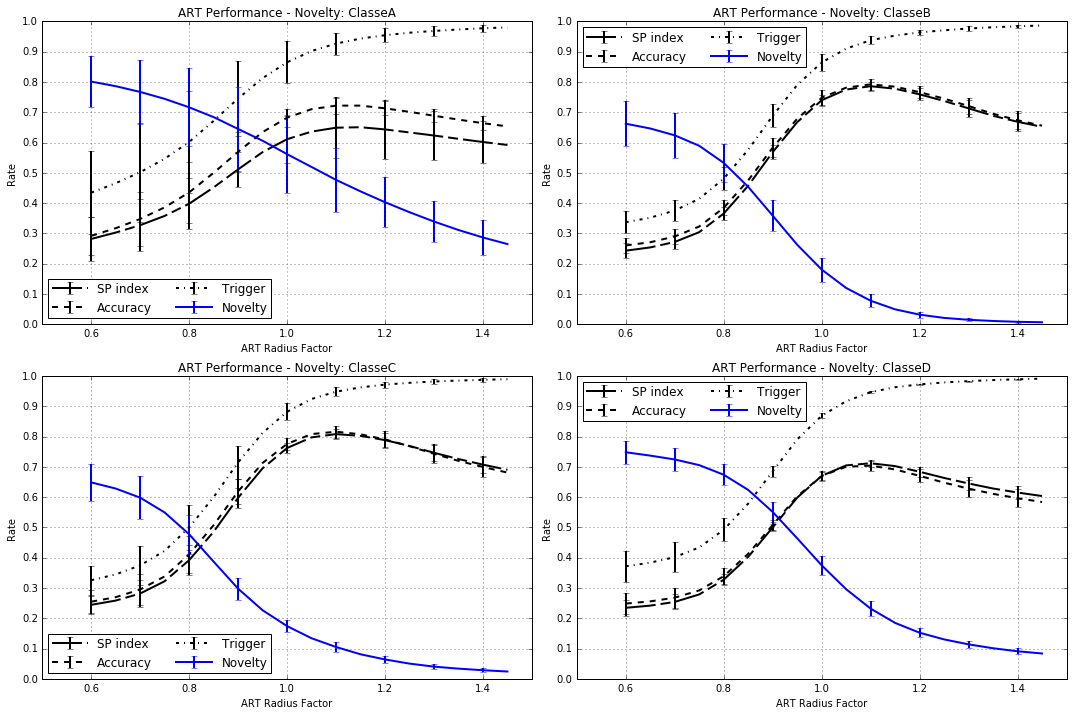

In [76]:
plt.figure(figsize=(15,10), facecolor='w')
art_thrs = np.arange(0.6, 1.5, 0.05)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    pcdtype = 'coo'
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]

    novelty  = np.zeros((NCV, len(art_thrs)))*np.nan  # novely efficiency
    accuracy = np.zeros((NCV, len(art_thrs)))  # Total accuracy
    trigger = np.zeros((NCV, len(art_thrs)))  # Sytem trigger
    effclass = np.zeros((tgt_classes.shape[0], NCV, len(art_thrs))) # Accuracy per class

    # LOOP OVER CV
    for icv in range(NCV):
        itst = artnet[pcdtype][novcls][icv].trn_info.ival
        # TEST NOVELTY
        # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
        # Where Eta is the radius control parameter (New Radius = Eta * Radius)
        S = art_out_nov[novcls][pcdtype][icv]
        R = art_rad_nov[novcls][pcdtype][icv]
        for ith, th in enumerate(art_thrs):
            Shat = R*(th-1) + S 
            Yhat = np.max(Shat, axis=1)
            novelty[icv, ith] = (Yhat < 0).sum() / float(Shat.shape[0])
        # LOOP OVER CLASSES
        for icls, cls in enumerate(tgt_classes):
            # Filter class
            itgt = T == cls
            idx = np.intersect1d(itst, np.nonzero(itgt)[0])
            # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
            # Where Eta is the radius control parameter (New Radius = Eta * Radius)
            S = art_out[novcls][pcdtype][icv]
            R = art_rad[novcls][pcdtype][icv]
            for ith, th in enumerate(art_thrs):
                Shat = R*(th-1) + S 
                Ycls = np.argmax(Shat, axis=1)
                Yhat = np.max(Shat, axis=1)
                effclass[icls, icv, ith] = ((Ycls[idx] == cls) & (Yhat[idx] >= 0)).sum() / float(idx.shape[0])
                accuracy[icv, ith] = accuracy[icv, ith] + ((Ycls[idx] == cls) & (Yhat[idx] >= 0)).sum()
                trigger[icv, ith] = trigger[icv, ith] + (Yhat[idx] >= 0).sum()            
        accuracy[icv] = accuracy[icv] / float(len(itst))
        trigger[icv]  = trigger[icv]  / float(len(itst))    
    # PLOT SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/nclasses) * np.mean(effclass, axis=0))
    plt.errorbar(art_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=2, label='SP index')
    # PLOT ACCURACY
    plt.errorbar(art_thrs, np.mean(accuracy, axis=0), np.std(accuracy, axis=0), fmt='--k',
                 errorevery=2, label='Accuracy')
    # PLOT SYSTEM TRIGGER
    plt.errorbar(art_thrs, np.mean(trigger, axis=0), np.std(trigger, axis=0), fmt='-.k',
                 errorevery=2, label='Trigger')
    # PLOT NOVELTY DETECTION
    h= plt.errorbar(art_thrs, np.mean(novelty, axis=0), np.std(novelty, axis=0), fmt='-b',
                    errorevery=2, label='Novelty')
    plt.title('ART Performance - Novelty: ' + novcls)
    plt.xlabel('ART Radius Factor')
    plt.ylabel('Rate')
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()

### Deflation

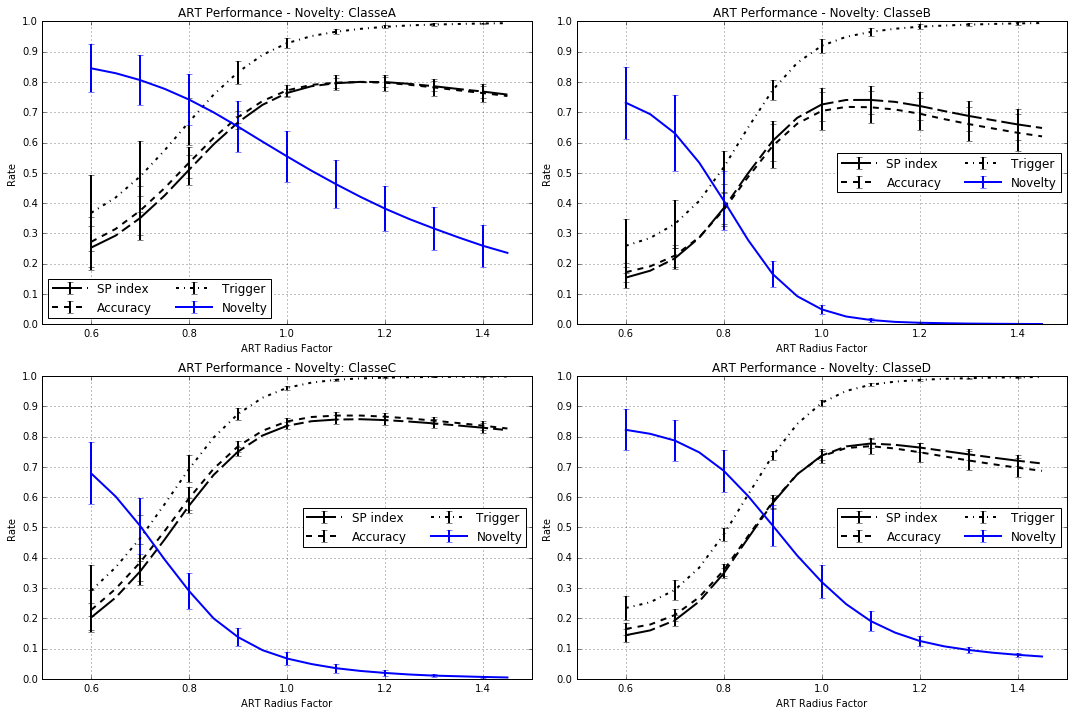

In [77]:
plt.figure(figsize=(15,10), facecolor='w')
art_thrs = np.arange(0.6, 1.5, 0.05)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    pcdtype = 'def'
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]

    novelty  = np.zeros((NCV, len(art_thrs)))*np.nan  # novely efficiency
    accuracy = np.zeros((NCV, len(art_thrs)))  # Total accuracy
    trigger = np.zeros((NCV, len(art_thrs)))  # Sytem trigger
    effclass = np.zeros((tgt_classes.shape[0], NCV, len(art_thrs))) # Accuracy per class

    # LOOP OVER CV
    for icv in range(NCV):
        itst = artnet[pcdtype][novcls][icv].trn_info.ival
        # TEST NOVELTY
        # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
        # Where Eta is the radius control parameter (New Radius = Eta * Radius)
        S = art_out_nov[novcls][pcdtype][icv]
        R = art_rad_nov[novcls][pcdtype][icv]
        for ith, th in enumerate(art_thrs):
            Shat = R*(th-1) + S 
            Yhat = np.max(Shat, axis=1)
            novelty[icv, ith] = (Yhat < 0).sum() / float(Shat.shape[0])
        # LOOP OVER CLASSES
        for icls, cls in enumerate(tgt_classes):
            # Filter class
            itgt = T == cls
            idx = np.intersect1d(itst, np.nonzero(itgt)[0])
            # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
            # Where Eta is the radius control parameter (New Radius = Eta * Radius)
            S = art_out[novcls][pcdtype][icv]
            R = art_rad[novcls][pcdtype][icv]
            for ith, th in enumerate(art_thrs):
                Shat = R*(th-1) + S 
                Ycls = np.argmax(Shat, axis=1)
                Yhat = np.max(Shat, axis=1)
                effclass[icls, icv, ith] = ((Ycls[idx] == cls) & (Yhat[idx] >= 0)).sum() / float(idx.shape[0])
                accuracy[icv, ith] = accuracy[icv, ith] + ((Ycls[idx] == cls) & (Yhat[idx] >= 0)).sum()
                trigger[icv, ith] = trigger[icv, ith] + (Yhat[idx] >= 0).sum()            
        accuracy[icv] = accuracy[icv] / float(len(itst))
        trigger[icv]  = trigger[icv]  / float(len(itst))    
    # PLOT SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/nclasses) * np.mean(effclass, axis=0))
    plt.errorbar(art_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=2, label='SP index')
    # PLOT ACCURACY
    plt.errorbar(art_thrs, np.mean(accuracy, axis=0), np.std(accuracy, axis=0), fmt='--k',
                 errorevery=2, label='Accuracy')
    # PLOT SYSTEM TRIGGER
    plt.errorbar(art_thrs, np.mean(trigger, axis=0), np.std(trigger, axis=0), fmt='-.k',
                 errorevery=2, label='Trigger')
    # PLOT NOVELTY DETECTION
    h= plt.errorbar(art_thrs, np.mean(novelty, axis=0), np.std(novelty, axis=0), fmt='-b',
                    errorevery=2, label='Novelty')
    plt.title('ART Performance - Novelty: ' + novcls)
    plt.xlabel('ART Radius Factor')
    plt.ylabel('Rate')
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.legend(loc='best', ncol=2)
    plt.grid(True)
    plt.tight_layout()

## Cooperative x Deflation

[0, 1, 0, 1]

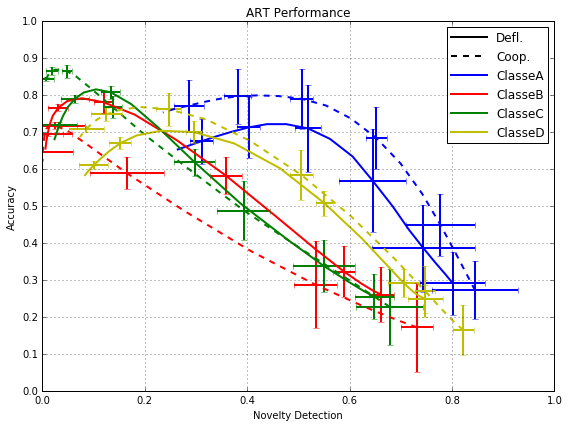

In [75]:
plt.figure(figsize=(8,6), facecolor='w')
art_thrs = np.arange(0.6, 1.5, 0.05)
# LOOP OVER NOVELTIES
for inov, novcls in enumerate(noveltyclasses):
    NCV = cvPar[novcls]['CVNSel']
    T = np.argmax(target[novcls], axis=1)
    tgt_classes = np.unique(T)
    nclasses = tgt_classes.shape[0]
    novelty = {}
    accuracy = {}
    for pcdtype in ('coo','def'):
        novelty[pcdtype]  = np.zeros((NCV, len(art_thrs)))*np.nan  # novely efficiency
        accuracy[pcdtype] = np.zeros((NCV, len(art_thrs)))  # Total accuracy
        # LOOP OVER CV
        for icv in range(NCV):
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            # TEST NOVELTY
            # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
            # Where Eta is the radius control parameter (New Radius = Eta * Radius)
            S = art_out_nov[novcls][pcdtype][icv]
            R = art_rad_nov[novcls][pcdtype][icv]
            for ith, th in enumerate(art_thrs):
                Shat = R*(th-1) + S 
                Yhat = np.max(Shat, axis=1)
                novelty[pcdtype][icv, ith] = (Yhat < 0).sum() / float(Shat.shape[0])
            # LOOP OVER CLASSES
            for icls, cls in enumerate(tgt_classes):
                # Filter class
                itgt = T == cls
                idx = np.intersect1d(itst, np.nonzero(itgt)[0])
                # New similarity for the i-th neuron: Shat_i = Radius_i(Eta - 1) + S_i
                # Where Eta is the radius control parameter (New Radius = Eta * Radius)
                S = art_out[novcls][pcdtype][icv]
                R = art_rad[novcls][pcdtype][icv]
                for ith, th in enumerate(art_thrs):
                    Shat = R*(th-1) + S 
                    Ycls = np.argmax(Shat, axis=1)
                    Yhat = np.max(Shat, axis=1)
                    accuracy[pcdtype][icv, ith] = accuracy[pcdtype][icv, ith] + \
                                                  ((Ycls[idx] == cls) & (Yhat[idx] >= 0)).sum()
            accuracy[pcdtype][icv] = accuracy[pcdtype][icv] / float(len(itst))
    # PLOT COOPERATIVE
    icls = np.nonzero(classes == novcls)[0][0]
    hdef = plt.errorbar(np.mean(novelty['coo'], axis=0), np.mean(accuracy['coo'], axis=0),
                        np.std(novelty['coo'], axis=0),np.std(accuracy['coo'], axis=0), fmt='-',
                        color=colors[icls], errorevery=3, label=novcls + ' Coo.')
    # PLOT DEFLATION
    icls = np.nonzero(classes == novcls)[0][0]
    hcoo = plt.errorbar(np.mean(novelty['def'], axis=0), np.mean(accuracy['def'], axis=0),
                        np.std(novelty['def'], axis=0),np.std(accuracy['def'], axis=0), fmt='--',
                        color=colors[icls], errorevery=3, label=novcls + ' Def.')
# LABELS
leg_handlers = []
leg_labels = []
h = plt.plot([], [], ls='-', c='k')[0]
leg_handlers.append(h)
leg_labels.append('Defl.')
h = plt.plot([], [], ls='--', c='k')[0]
leg_handlers.append(h)
leg_labels.append('Coop.')    
for inov, novcls in enumerate(noveltyclasses):
    icls = np.nonzero(classes == novcls)[0][0]
    h = plt.plot([], [], ls='-', color=colors[icls])[0]
    leg_handlers.append(h)
    leg_labels.append(novcls)  
    
plt.title('ART Performance')
plt.xlabel('Novelty Detection')
plt.ylabel('Accuracy')
plt.gca().set_yticks(np.linspace(0,1,11))
plt.legend(leg_handlers, leg_labels, loc='best', ncol=1).get_frame().set_facecolor('1')
plt.grid(True)
plt.tight_layout()
plt.axis([0,1,0,1])

# ART Node Importance

In [ ]:
novcls = 'ClasseA'

## Cooperative

### Hits Density

Are there nodes more important than others, considering that they have more hits than others? How does this evolve considering different number of PCD?

In [ ]:
plt.figure(figsize=(10,5))
hbins = np.arange(0,500, 20)
pcd_values = np.array(artnet_coo[novcls][0].keys())
mat = [[np.histogram(np.sum(art.neuron_class_hits, axis=1),hbins)[0].tolist() for art in cv.values()] \
                                                                              for cv in artnet_coo[novcls]]
mat = np.log10(mat)
mat = np.mean(mat, axis=0)
ms = plt.matshow(mat, fignum=0, aspect='auto', cmap='gray_r')
plt.xlabel('Hits Per Node')
plt.ylabel('# PCD')
xstep = len(hbins) / len(plt.gca().get_xticks())
plt.xticks(range(mat.shape[1]), hbins[1:])

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")

plt.colorbar(ms, cax=cax, label='Count of Nodes (log10)');

### Relation of Radius and Classes Representation

How does the radius impact on the importance of the nodes? The plot shows the max. Class rate (the rate of the class in each node - number of hits for class C / total number of events of class C) and the max. Node freq. (the class that is better represented by this node - number of hits for class C / total number of hits).

- Must be for one specific CV because the number of nodes is not constant

In [ ]:
icv = 4
plt.figure(figsize=(12,12))
pcd_values = [4, 10, 20, 40]
for ipcd, npcd in enumerate(pcd_values):
    plt.subplot(2,2,ipcd+1)
    plt.scatter(artnet_coo[novcls][icv][npcd].radius, np.max(artnet_coo[novcls][icv][npcd].neuron_class_rate, axis=1),
                color='b', label='Class rate');
    plt.scatter(artnet_coo[novcls][icv][npcd].radius, np.max(artnet_coo[novcls][icv][npcd].neuron_class_freq, axis=1),
                color='r', label='Node rate');
    plt.ylim((0,1))
    plt.grid(True)
    plt.xlabel('Node Radius')
    plt.ylabel('Rate')
    plt.title('#PCD: %i (CV: %i)'%(npcd, icv))
    plt.legend(loc='center left', numpoints=1)

### Radius Distribution

How does the node radius evolve considering different number of PCD? Isolated events would be mapped with few nodes, with possibly small radius.

In [ ]:
plt.figure(figsize=(10,5))
hbins = np.linspace(0,10, 51)
pcd_values = np.array(artnet_coo[novcls][0].keys())
mat = [[np.histogram(art.radius,hbins)[0].tolist() for art in cv.values()] \
                                                   for cv in artnet_coo[novcls]]

mat = np.mean(mat, axis=0)
ms = plt.matshow(mat, fignum=0, aspect='auto', cmap='gray_r',
                 extent=[hbins[0], hbins[-1], pcd_values[-1],pcd_values[0]])
plt.xlabel('Node Radius')
plt.ylabel('# PCD')
plt.grid(True)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")

plt.colorbar(ms, cax=cax, label='Count of Nodes');

## Deflation

### Hits Density

In [ ]:
plt.figure(figsize=(10,5))
hbins = np.arange(0,500, 20)
pcd_values = np.array(artnet_coo[novcls][0].keys())
mat = [[np.histogram(np.sum(art.neuron_class_hits, axis=1),hbins)[0].tolist() for art in cv.values()] \
                                                                              for cv in artnet_def[novcls]]
mat = np.log10(mat)
mat = np.mean(mat, axis=0)
ms = plt.matshow(mat, fignum=0, aspect='auto', cmap='gray_r')
plt.xlabel('Hits Per Node')
plt.ylabel('# PCD')
xstep = len(hbins) / len(plt.gca().get_xticks())
plt.xticks(range(mat.shape[1]), hbins[1:])

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")

plt.colorbar(ms, cax=cax, label='Count of Nodes (log10)');

### Relation of Radius and Classes Representation

In [ ]:
icv = 4
plt.figure(figsize=(12,12))
pcd_values = [4, 10, 20, 40]
for ipcd, npcd in enumerate(pcd_values):
    plt.subplot(2,2,ipcd+1)
    plt.scatter(artnet_def[novcls][icv][npcd].radius, np.max(artnet_def[novcls][icv][npcd].neuron_class_rate, axis=1),
                color='b', label='Class rate');
    plt.scatter(artnet_def[novcls][icv][npcd].radius, np.max(artnet_def[novcls][icv][npcd].neuron_class_freq, axis=1),
                color='r', label='Node rate');
    plt.ylim((0,1))
    plt.grid(True)
    plt.xlabel('Node Radius')
    plt.ylabel('Rate')
    plt.title('#PCD: %i (CV: %i)'%(npcd, icv))
    plt.legend(loc='center left', numpoints=1)

### Radius Distribution

In [ ]:
plt.figure(figsize=(10,5))
hbins = np.linspace(0,int(artnet_def[novcls][0].values()[-1].radius.max()), 51)
pcd_values = np.array(artnet_def[novcls][0].keys())
mat = [[np.histogram(art.radius,hbins)[0].tolist() for art in cv.values()] \
                                                   for cv in artnet_def[novcls]]

mat = np.mean(mat, axis=0)
ms = plt.matshow(mat, fignum=0, aspect='auto', cmap='gray_r',
                 extent=[hbins[0], hbins[-1], pcd_values[-1],pcd_values[0]])
plt.xlabel('Node Radius')
plt.ylabel('# PCD')
plt.grid(True)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "3%", pad="2%")

plt.colorbar(ms, cax=cax, label='Count of Nodes');

# Simulate ART

In [ ]:
art_thrs = np.arange(0,1.01,0.005)
art_winner = {}
art_winner_nov = {}
art_out = {}
art_out_nov = {}
art_error = {}
art_raw_data = {}
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    art_out[novcls] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
    art_out_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    art_winner[novcls] = np.zeros((NCV, target[novcls].shape[0]))
    art_winner_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0]))    
    art_error[novcls] = np.zeros((NCV, art_thrs.shape[0]))
    # Loop over CV
    for icv in range(NCV):
        # Normalize output
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y) 
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        art_out[novcls][icv] = Y 
        """
        dmax = 5*R
        art_norm[novcls][icv] = np.tanh(Y/dmax)
        art_norm[novcls][icv] = 1 - art_norm[novcls][icv] # Invert: close to 1 is good!
        # Adjust range
        art_norm[novcls][icv][art_norm[novcls][icv] < 0.5] = 0.5
        art_norm[novcls][icv][art_norm[novcls][icv] > 0.9] = 0.9
        art_norm[novcls][icv] = (art_norm[novcls][icv] - 0.5) / 0.4 
        # Estimate Error from test set
        itrn = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = art_norm[novcls][icv][itrn]
        T = target[novcls][itrn]
        Ymax = np.max(Y, axis=1)
        Ymax = Ymax[np.argmax(Y, axis=1) != np.argmax(T, axis=1)]
        art_error[novcls][icv] = np.array([(Ymax >= th).sum() for th in art_thrs]) / float(len(itrn))
        """
        ############################################ NOVELTY NORMALIZED OUTPUT
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        Y = artnet[novcls][icv].outputs(Y)
        art_out_nov[novcls][icv] = Y 
        
        """
        Y = artnet[novcls][icv].outputs(Y)
        art_norm_nov[novcls][icv] = np.tanh(Y/dmax)
        art_norm_nov[novcls][icv] = 1 - art_norm_nov[novcls][icv]
        # Adjust range
        art_norm_nov[novcls][icv][art_norm_nov[novcls][icv] < 0.5] = 0.5
        art_norm_nov[novcls][icv][art_norm_nov[novcls][icv] > 0.9] = 0.9
        art_norm_nov[novcls][icv] = (art_norm_nov[novcls][icv] - 0.5) / 0.4         
        """
    break

# Plot Output

In [ ]:
print len(cvPar[novcls]['Indexes'][icv]['ITrn'])
print len(artnet[novcls][icv].neurons)

In [ ]:
icv = 0
novcls = 'ClasseA'
plt.figure(figsize=(12, 16))
nclasses = len(pcdlabels[novcls])
for icls, cls in enumerate(pcdlabels[novcls]):
    radius = artnet[novcls][icv].trn_initial_radius
    ##### Known classes
    itgt = target[novcls][:,icls] == 1
    for iout in range(art_out[novcls][icv].shape[1]):
        plt.subplot((nclasses + 1),(nclasses),(icls * nclasses) + iout + 1)
        plt.hist(art_out[novcls][icv][itgt, iout], 100, color='k')
        plt.yscale('log')
        plt.xlim([-1, np.max(art_out[novcls][icv][itgt,:])])
        plt.plot([radius, radius], plt.axis()[2:],'--r',lw=3)
        if icls == 0:
            plt.title(pcdlabels[novcls][iout])
    # Truth label
    plt.subplot((nclasses + 1),(nclasses),(icls * nclasses) + 1)
    plt.ylabel('Truth: ' + cls)
##### Novelty
for iout in range(art_out_nov[novcls][icv].shape[1]):
    plt.subplot((nclasses + 1),(nclasses),nclasses*nclasses + iout + 1)
    plt.hist(art_out_nov[novcls][icv][:, iout], 100, color='k')
    plt.yscale('log')
    plt.xlim([-1, np.max(art_out_nov[novcls][icv])])
    plt.plot([radius, radius], plt.axis()[2:],'--r',lw=3)    
    if iout == 0:
        plt.ylabel('Truth: Novelty')

## Plot Training Contention

In [ ]:
novcls = 'ClasseA'
icv = 0
npcd = 30

itrn = cvPar[novcls]['Indexes'][icv]['ITrn']
ival = cvPar[novcls]['Indexes'][icv]['IVal']

Xart = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
Xart = artnet[novcls][icv].trn_data_norm.transform(Xart) 
R = artnet[novcls][icv].trn_initial_radius
Yart = artnet[novcls][icv].classify(Xart)[1]
art_target = np.argmax(target[novcls], axis=1)

In [ ]:
plt.figure(figsize=(13,6))

dim1 = 7
dim2 = 23

# Truth
plt.subplot(1,2,1)
for clsnum, cls in enumerate(pcdlabels[novcls]):
    icls = np.nonzero(classes == cls)[0][0] 
    idx = np.intersect1d(itrn, np.nonzero(art_target == clsnum)[0])
    plt.plot(Xart[idx, dim1], Xart[idx, dim2], '.', color=colors[icls], alpha=0.1)
for ineuron in range(artnet[novcls][icv].neurons.shape[0]):
    clsnum = int(artnet[novcls][icv].classes[ineuron])
    if clsnum != -1: icls = np.nonzero(classes == pcdlabels[novcls][clsnum])[0][0]
    c = colors[icls] if clsnum != -1 else 'k'
    plt_neuron = plt.Circle(artnet[novcls][icv].neurons[ineuron,[dim1, dim2]],
                            artnet[novcls][icv].radius[ineuron],color=c,fill=False)
    plt.gca().add_artist(plt_neuron)
plt.axis('equal')
plt.title('Truth')
plt.xlabel('Dim '+str(dim1))
plt.ylabel('Dim '+str(dim2))
# Simulation
plt.subplot(1,2,2)
for cls in np.unique(Yart):
    #if cls != -1: continue
    idx = np.intersect1d(ival, np.nonzero(Yart == cls)[0])
    if cls == -1:
        c = 'k'
    else:
        clsname = pcdlabels[novcls][int(cls)]
        c = colors[np.nonzero(classes == clsname)[0][0]]
    plt.plot(Xart[idx, dim1], Xart[idx, dim2], '.', color=c, alpha=0.1)
for ineuron in range(artnet[novcls][icv].neurons.shape[0]):
    clsnum = int(artnet[novcls][icv].classes[ineuron])
    if clsnum != -1: icls = np.nonzero(classes == pcdlabels[novcls][clsnum])[0][0]
    c = colors[icls] if clsnum != -1 else 'k'
    plt_neuron = plt.Circle(artnet[novcls][icv].neurons[ineuron,[dim1, dim2]],
                            artnet[novcls][icv].radius[ineuron],color=c,fill=False)
    plt.gca().add_artist(plt_neuron)
plt.axis('equal')
plt.title('Classification')
plt.xlabel('Dim '+str(dim1))
plt.ylabel('Dim '+str(dim2))


## ART Normalized Output and Error

In [ ]:
art_thrs = np.arange(0,1.01,0.005)
art_norm = {}
art_norm_nov = {}
art_error = {}
art_raw_data = {}
nsamples = 1000
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    art_norm[novcls] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
    art_norm_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    art_error[novcls] = np.zeros((NCV, art_thrs.shape[0]))
    # Loop over CV
    for icv in range(NCV):
        # Normalize output
        Y = pcdnet[novcls][icv].W[0].dot(data[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y) 
        R = artnet[novcls][icv].trn_initial_radius
        Y = artnet[novcls][icv].outputs(Y)
        dmax = 5*R
        art_norm[novcls][icv] = np.tanh(Y/dmax)
        art_norm[novcls][icv] = 1 - art_norm[novcls][icv] # Invert: close to 1 is good!
        # Adjust range
        art_norm[novcls][icv][art_norm[novcls][icv] < 0.5] = 0.5
        art_norm[novcls][icv][art_norm[novcls][icv] > 0.9] = 0.9
        art_norm[novcls][icv] = (art_norm[novcls][icv] - 0.5) / 0.4 
        # Estimate Error from test set
        itrn = cvPar[novcls]['Indexes'][icv]['IVal']
        Y = art_norm[novcls][icv][itrn]
        T = target[novcls][itrn]
        Ymax = np.max(Y, axis=1)
        Ymax = Ymax[np.argmax(Y, axis=1) != np.argmax(T, axis=1)]
        art_error[novcls][icv] = np.array([(Ymax >= th).sum() for th in art_thrs]) / float(len(itrn))
        ############################################ NOVELTY NORMALIZED OUTPUT
        Y = pcdnet[novcls][icv].W[0].dot(data_nov[novcls].T).T
        Y = artnet[novcls][icv].trn_data_norm.transform(Y)
        Y = artnet[novcls][icv].outputs(Y)
        art_norm_nov[novcls][icv] = np.tanh(Y/dmax)
        art_norm_nov[novcls][icv] = 1 - art_norm_nov[novcls][icv]

        # Adjust range
        art_norm_nov[novcls][icv][art_norm_nov[novcls][icv] < 0.5] = 0.5
        art_norm_nov[novcls][icv][art_norm_nov[novcls][icv] > 0.9] = 0.9
        art_norm_nov[novcls][icv] = (art_norm_nov[novcls][icv] - 0.5) / 0.4         

In [ ]:
# ERROR
plt.figure()
workclass = 'ClasseA'
plt.errorbar(art_thrs, np.mean(art_error[workclass], axis=0), np.std(art_error[workclass], axis=0), errorevery=10)
plt.ylabel('Decision error rate (Test set)')
plt.xlabel('ART Decision Threshold')
plt.xlim([0,1])
#plt.ylim([0,1])
plt.grid(True)

In [ ]:
workclass = 'ClasseD'
testclass = 'ClasseB'
icv = 0
plt.figure(figsize=(15,10))
plt.suptitle('Novelty: ' + workclass+ '. Distance to ' + testclass + ' nodes')
# Non-normalized
plt.subplot(3,1,1)
Y = pcdnet[workclass][icv].W[0].dot(data[workclass].T).T
Y = artnet[workclass][icv].trn_data_norm.transform(Y) 
R = artnet[workclass][icv].trn_initial_radius
Y = artnet[workclass][icv].outputs(Y)
dmax = 5*R
plt.hist(Y[:,0], 100);
ax = plt.axis()
plt.plot([dmax, dmax], [ax[2], ax[3]], '--r',lw=3)
plt.ylabel('Count')
plt.xlabel('Non-normalized ART Distance')
plt.yscale('log')
plt.grid(True)
# Normalized by the tanh and 5*radius
plt.subplot(3,1,2)
Y = 1 - np.tanh(Y/dmax) 
plt.hist(Y[:,0], 100);
ax = plt.axis()
plt.ylabel('Count')
plt.xlabel('Normalized ART Distance by 1 - tanh(Y/(5*Radius))')
plt.yscale('log')
plt.grid(True)
# Afer full normalization
plt.subplot(3,1,3)
plt.hist(art_norm[workclass][icv][:,0], 100);
plt.ylabel('Count')
plt.xlabel('ART Distance re-normalized to previous [0.5, 0.9]')
plt.yscale('log')
plt.grid(True)

## MLP Output and Error

In [ ]:
mlp_out = {}
mlp_out_nov = {}
mlp_error = {}
mlp_thrs = np.arange(-1,1.01,0.01)
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    mlp_out[novcls] = np.zeros((NCV, target[novcls].shape[0], target[novcls].shape[1]))
    mlp_out_nov[novcls] = np.zeros((NCV, data_nov[novcls].shape[0], target[novcls].shape[1]))
    mlp_error[novcls] = np.zeros((NCV, len(mlp_thrs)))
    # Loop over CV
    for icv in range(NCV):
        # Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        T = target[novcls]
        if PCDType == 'pcd_constructive':
            Y = pcdnet[novcls][icv].feedforward(data[novcls])
        elif PCDType == 'pcd_independent':
            Y = pcdclf[novcls][icv].feedforward(pcdnet[novcls][icv].feedforward(data[novcls]))
        mlp_out[novcls][icv] = Y
        Ytst = Y[itst]
        Ttst = T[itst]
        Ymax = np.max(Ytst, axis=1)
        Ymax = Ymax[np.argmax(Ytst, axis=1) != np.argmax(Ttst, axis=1)]
        mlp_error[novcls][icv] = np.array([(Ymax>=th).sum() for th in mlp_thrs]) / float(len(Ytst))
        # NOVELTY
        if PCDType == 'pcd_constructive':
            Y = pcdnet[novcls][icv].feedforward(data_nov[novcls])
        elif PCDType == 'pcd_independent':
            Y = pcdclf[novcls][icv].feedforward(pcdnet[novcls][icv].feedforward(data_nov[novcls]))
        mlp_out_nov[novcls][icv] = Y

In [ ]:
# ERROR
plt.figure()
plt.errorbar(mlp_thrs, np.mean(mlp_error[workclass], axis=0), np.std(mlp_error[workclass], axis=0), errorevery=10)
plt.ylabel('Decision error rate (Train set)')
plt.xlabel('MLP Decision Threshold')
plt.xlim([0,1])
plt.grid(True)

## ART Single Detection

In [ ]:
plt.figure(figsize=(15,10), facecolor='w')
det_target = 0.8
art_det_thr = {}
best_art = {}
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    # PLot Known classes
    effnov = np.zeros((NCV, len(art_thrs)))*np.nan  # novely efficiency
    effclass  = np.zeros((target[novcls].shape[1], NCV, len(art_thrs)))
    for iout in range(target[novcls].shape[1]):
        # Loop over cross-validation
        tpr = np.zeros((NCV, len(art_thrs))) * np.nan # true positive rate
        for icv in range(NCV):
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            Yout = art_norm[novcls][icv][itst]
            T = target[novcls][itst]
            # Loop over thresholds
            for ithr, thr in enumerate(art_thrs):
                # True Positive: greater than the threshold and the other neurons.
                TP = np.sum((Yout[:, iout]>=thr) & (np.argmax(Yout, axis=1) == iout) & (T[:, iout] == 1))
                tpr[icv,ithr] = TP / float(np.sum((T[:, iout] == 1)))                
        effclass[iout] = tpr
        # Plot
        icls = np.nonzero(classes == pcdlabels[novcls][iout])[0][0]
        plt.errorbar(art_thrs, np.nanmean(tpr, axis=0), np.nanstd(tpr, axis=0), dashes=dashes[icls],
                     color=colors[icls], errorevery=10, label=pcdlabels[novcls][iout])
    # Plot SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/T.shape[1]) * np.mean(effclass, axis=0))
    plt.errorbar(art_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=10, label='SP index')
    # Plot total accuracy (efficiency of known-classes)
    efftot = np.zeros((NCV, len(art_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Yout = art_norm[novcls][icv][itst]
        T = target[novcls][itst]
        # Loop over thresholds
        for ithr, thr in enumerate(art_thrs):
            # True Positive: greater than the threshold and correct neuron.
            TP = np.sum(((np.max(Yout, axis=1) >= thr) & (np.argmax(Yout, axis=1) == np.argmax(T, axis=1))))
            efftot[icv,ithr] = TP / float(Yout.shape[0])
    plt.errorbar(art_thrs, np.mean(efftot, axis=0), np.std(efftot, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')
    # System trigger (detection rate)
    efftrg = np.zeros((NCV, len(art_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Yout = art_norm[novcls][icv][itst]
        # Loop over thresholds
        for ithr, thr in enumerate(art_thrs):
            # Just need an output greater than the thrshold
            TP = np.sum((np.max(Yout, axis=1)>=thr))
            efftrg[icv,ithr] = TP / float(Yout.shape[0])
    plt.errorbar(art_thrs, np.mean(efftrg, axis=0), np.std(efftrg, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    
    # Plot Novelty
    for icv in range(NCV):
        Ynov = art_norm_nov[novcls][icv]
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in art_thrs], 'f')/Ynov.shape[0]
    plt.errorbar(art_thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                 fmt='k-', errorevery=10, label='Novelty')
    # PRINT INFO
    idx = np.nonzero(np.mean(efftrg, axis=0) >= det_target)[0][-1]
    idx = np.nonzero(np.mean(efftrg, axis=0) >= det_target)[0][-1]
    idx = np.nonzero(np.mean(efftot, axis=0) >= det_target)[0][-1]    
    print novcls, '  Trig: %5.2f +- %5.2f, Nov: %5.2f +- %5.2f, at thrs: %5.3f'%(np.mean(efftrg, axis=0)[idx]*100,
                                                                                 np.std (efftrg, axis=0)[idx]*100,
                                                                                 np.mean(effnov, axis=0)[idx]*100,
                                                                                 np.std (effnov, axis=0)[idx]*100,
                                                                                 art_thrs[idx]),
    print ' acc: %5.2f +- %5.2f'%(np.mean(efftot, axis=0)[idx]*100, np.std(efftot, axis=0)[idx]*100),
    print ' sp: %5.2f +- %5.2f'%(np.mean(effsp, axis=0)[idx]*100, np.std(effsp, axis=0)[idx]*100)
    # Operation parameters
    best_art[novcls] = efftrg[:,idx].argmax()
    art_det_thr[novcls] = art_thrs[idx]
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(0,1.25,0.25))
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid()
    plt.title('Novelty: ' + novcls)
    plt.xlabel('Decision Threshold')
    plt.ylabel('Efficiency/Outlier Rate')
    plt.legend(loc='center right').get_frame().set_facecolor('1')

## MLP Single Detection

In [ ]:
plt.figure(figsize=(15,10), facecolor='w')
det_target = 0.8
mlp_det_thr = {}
best_mlp = {}
# Loop over novelties
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    # PLot Known classes
    effnov = np.zeros((NCV, len(mlp_thrs)))*np.nan  # novely efficiency
    effclass  = np.zeros((T.shape[1], NCV, len(mlp_thrs)))
    for iout in range(T.shape[1]):
        # Loop over cross-validation
        tpr = np.zeros((NCV, len(mlp_thrs))) * np.nan # true positive rate
        for icv in range(NCV):
            Yout = mlp_out[novcls][icv]
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            # Loop over thresholds
            for ithr, thr in enumerate(mlp_thrs):
                # True Positive: greater than the threshold and the other neurons.
                TP = np.sum((Yout[itst, iout]>=thr) & (np.argmax(Yout[itst], axis=1) == iout) & (T[itst, iout] == 1))
                tpr[icv,ithr] = TP / float(np.sum((T[itst, iout] == 1)))
        effclass[iout] = tpr
        # Plot
        icls = np.nonzero(classes == pcdlabels[novcls][iout])[0][0]
        plt.errorbar(mlp_thrs, np.nanmean(tpr, axis=0), np.nanstd(tpr, axis=0), dashes=dashes[icls],
                     color=colors[icls], errorevery=10, label=pcdlabels[novcls][iout])
    # Plot SP
    effsp = np.sqrt(np.power(np.prod(effclass, axis=0), 1.0/T.shape[1]) * np.mean(effclass, axis=0))
    plt.errorbar(mlp_thrs, np.mean(effsp, axis=0), np.std(effsp, axis=0), fmt='k', dashes=[30, 5, 10, 5],
                 errorevery=10, label='SP index')
    # Plot total accuracy (efficiency of known-classes)
    efftot = np.zeros((NCV, len(mlp_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = mlp_out[novcls][icv]
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        # Loop over thresholds
        for ithr, thr in enumerate(mlp_thrs):
            # True Positive: greater than the threshold and correct neuron.
            TP = np.sum(((np.max(Yout, axis=1) >= thr) & (np.argmax(Yout, axis=1) == np.argmax(T, axis=1)))[itst])
            efftot[icv,ithr] = TP / float(len(itst))
    plt.errorbar(mlp_thrs, np.mean(efftot, axis=0), np.std(efftot, axis=0), fmt='--k',
                 errorevery=10, label='Accuracy')
    # Plot System trigger rate
    efftrg = np.zeros((NCV, len(mlp_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = mlp_out[novcls][icv]
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        # Loop over thresholds
        for ithr, thr in enumerate(mlp_thrs):
            # Just need an output greater than the thrshold
            TP = np.sum((np.max(Yout, axis=1)[itst]>=thr))
            efftrg[icv,ithr] = TP / float(len(itst))
    plt.errorbar(mlp_thrs, np.mean(efftrg, axis=0), np.std(efftrg, axis=0), fmt='-.k',
                 errorevery=10, label='Trigger')
    
    # Plot Novelty
    for icv in range(NCV):
        Ynov = mlp_out_nov[novcls][icv]
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in mlp_thrs], 'f')/Ynov.shape[0]
    plt.errorbar(mlp_thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                 fmt='k-', errorevery=10, label='Novelty')
    # PRINT INFO
    #idx = np.nonzero(np.mean(efftrg, axis=0) >= det_target)[0][-1]
    #idx = np.nonzero(np.mean(effsp, axis=0) >= det_target)[0][-1]
    idx = np.nonzero(np.mean(efftot, axis=0) >= det_target)[0][-1]
    print novcls, '  Trig: %5.2f +- %5.2f, Nov: %5.2f +- %5.2f, at thrs: %5.3f'%(np.mean(efftrg, axis=0)[idx]*100,
                                                                                 np.std (efftrg, axis=0)[idx]*100,
                                                                                 np.mean(effnov, axis=0)[idx]*100,
                                                                                 np.std (effnov, axis=0)[idx]*100,
                                                                                 mlp_thrs[idx]),
    print ' acc: %5.2f +- %5.2f'%(np.mean(efftot, axis=0)[idx]*100, np.std(efftot, axis=0)[idx]*100),
    print ' sp: %5.2f +- %5.2f'%(np.mean(effsp, axis=0)[idx]*100, np.std(effsp, axis=0)[idx]*100)
    # Operation parameters
    best_mlp[novcls] = efftrg[:,idx].argmax()
    mlp_det_thr[novcls] = mlp_thrs[idx]
    # Plot aspects
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.arange(-1,1.25,0.25))
    plt.xlim([-1,1])
    plt.ylim([0,1])
    plt.grid()
    plt.xlabel('Decision Threshold')
    plt.ylabel('Efficiency/Outlier Rate')
    plt.title('Novelty: ' + novcls)
    plt.legend(loc='center left', ncol=2).get_frame().set_facecolor('1')

## Consultive: MLP to ART

In [ ]:
# Loop over novelty classes
plt.figure(figsize=(15,10), facecolor='w')
# Loop over novelties
art_radius = [0.5, 0.6, 0.8]
mlp_nonnov_thr =  0.7
mlp_nov_thr = -0.5
for inov, novcls in enumerate(noveltyclasses):
    print 'Novelty: ', novcls
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ MLP Alone
    # Plot System trigger rate
    efftrg = np.zeros((NCV, len(mlp_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        Yout = mlp_out[novcls][icv]
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        # Loop over thresholds
        for ithr, thr in enumerate(mlp_thrs):
            # Just need an output greater than the thrshold
            TP = np.sum((np.max(Yout, axis=1)[itst]>=thr))
            efftrg[icv,ithr] = TP / float(len(itst))
    h = plt.errorbar(mlp_thrs, np.mean(efftrg, axis=0), np.std(efftrg, axis=0), fmt='-.k',
                     errorevery=10, label='Trigger')
    leg_handlers.append(h)
    leg_labels.append('Trigger')
    # Plot Novelty
    for icv in range(NCV):
        Ynov = mlp_out_nov[novcls][icv]
        effnov[icv] = np.array([np.sum(np.max(Ynov, axis=1) < thr) for thr in mlp_thrs], 'f')/Ynov.shape[0]
    h = plt.errorbar(mlp_thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                     fmt='k-', errorevery=10, label='Novelty')
    leg_handlers.append(h)
    leg_labels.append('Novelty')
    ############################################################### Associate ART and MLP
    for ir, art_th in enumerate(art_radius):
        probdist = np.zeros((NCV, len(mlp_thrs)))
        probnov = np.zeros((NCV, len(mlp_thrs)))
        # Loop over CV
        for icv in range(NCV):
            # Known-classes
            itst = cvPar[novcls]['Indexes'][icv]['IVal']
            Ymlp = mlp_out[novcls][icv][itst].max(axis=1)
            Yart = art_norm[novcls][icv][itst].max(axis=1)
            for i, th in enumerate(mlp_thrs):
                if th > mlp_nonnov_thr:
                    mlp_dec = (Ymlp >= mlp_nonnov_thr)
                elif th > mlp_nonnov_thr:
                    mlp_dec = ((Ymlp >= mlp_nonnov_thr) & \
                               ((Ymlp >= th) | ((Ymlp < mlp_nonnov_thr)&(Yart >= art_th))))
                else:
                    mlp_dec = Ymlp >= mlp_nov_thr
                probdist[icv, i] = mlp_dec.sum() / float(len(itst))
            # Novelty
            Ymlp = mlp_out_nov[novcls][icv].max(axis=1)
            Yart = art_norm_nov[novcls][icv].max(axis=1)
            for i, th in enumerate(mlp_thrs):
                if th < mlp_nov_thr:
                    mlp_dec = (Ymlp < mlp_nov_thr)
                elif th < mlp_det_thr:
                     mlp_dec = ((Ymlp < mlp_nonnov_thr) & \
                                ((Ymlp < mlp_nov_thr) | \
                                 ((Ymlp >= mlp_nov_thr) & (Ymlp < th) & (Yart < art_th))))
                else:
                    mlp_dec = Ymlp < mlp_nonnov_thr
                probnov[icv, i] = (mlp_dec).sum() / float(Ymlp.shape[0])
        # Plot Known classes
        icls = np.nonzero(classes == novcls)[0][0]
        plt.errorbar(mlp_thrs, np.mean(probdist, axis=0), np.std(probdist, axis=0), fmt='-.',
                     color=colors[icls], errorevery=10,
                     markevery=10, marker=markers[ir])
        # Plot Novelty
        icls = np.nonzero(classes == novcls)[0][0]
        h = plt.errorbar(mlp_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='-',
                         color=colors[icls], errorevery=10,
                         markevery=10, marker=markers[ir])
        leg_handlers.append(h)
        leg_labels.append('ART: %.2f'%art_th)
    # Plot Confusion Thresholds
    plt.plot([mlp_nonnov_thr, mlp_nonnov_thr], [0, 1], 'k--', lw=4)
    h = plt.plot([mlp_nov_thr, mlp_nov_thr], [0, 1], 'k--', lw=4)
    leg_handlers.append(h[0])
    leg_labels.append('Consulting limits')
        
    plt.title('Trigger and Novelty: ' + novcls)
    plt.gca().set_yticks(np.linspace(-1,1,21))
    plt.gca().set_xticks(np.linspace(-1,1,11))
    #plt.gca().axis([mlp_nov_thr-0.1, mlp_det_thr+0.1,0,1])
    plt.gca().axis([-1,1,0,1])
    plt.xlabel('MLP Threshold')
    plt.ylabel('Efficiency/Outlier Rate')
    plt.legend(leg_handlers, leg_labels, loc='best').get_frame().set_facecolor('1')
    plt.grid(True)

## Ensemble: weighting each output by its error

In [ ]:
# Loop over novelty classes
plt.figure(figsize=(15,10), facecolor='w')
# Loop over novelties
art_factor = 1
ensemble_thrs = art_thrs
ens_det_thr = {}
best_ens = {}
ens_out = {}
ens_out_nov = {}
det_target = 0.8
for inov, novcls in enumerate(noveltyclasses):
    plt.subplot(2,2,inov+1)
    NCV = cvPar[novcls]['CVNSel']
    T = target[novcls]
    leg_handlers = []
    leg_labels = []
    ############################################################ MLP Alone
    # Plot System trigger rate
    efftrg = np.zeros((NCV, len(ensemble_thrs)))*np.nan  # total efficiency (known-classes)    
    effacc = np.zeros((NCV, len(ensemble_thrs)))*np.nan  # total efficiency (known-classes)    
    effsps = np.zeros((NCV, len(ensemble_thrs)))*np.nan  # total efficiency (known-classes)    
    for icv in range(NCV):
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Yout = (mlp_out[novcls][icv][itst].max(axis=1) + 1)/2
        Ycls = np.argmax(mlp_out[novcls][icv][itst], axis=1)
        Tcls = np.argmax(T[itst], axis=1)
        effs = np.zeros((T.shape[1],ensemble_thrs.shape[0]))
        # Loop over thresholds
        for ithr, thr in enumerate(ensemble_thrs):
            # Just need an output greater than the thrshold
            TP = (Yout >= thr).sum()
            efftrg[icv,ithr] = TP / float(Yout.shape[0])
            TP = ((Yout >= thr) & (Ycls == Tcls)).sum()
            effacc[icv,ithr] = TP / float(Yout.shape[0])
        for icls in range(effs.shape[0]):
            effs[icls] = [((Yout >= th) &
                           (Ycls == Tcls) &
                           (Tcls == icls)).sum()/ float((Tcls==icls).sum()) for th in ensemble_thrs]
        effsps[icv] = np.sqrt(np.power(np.prod(effs,axis=0), 1.0/effs.shape[0])*np.mean(effs, axis=0))
    
    h = plt.errorbar(ensemble_thrs, np.mean(effsps, axis=0), np.std(effsps, axis=0), fmt='o-.k',
                     errorevery=10, label='SP', markevery=50)
    leg_handlers.append(h)
    leg_labels.append('MLP - SP')
    h = plt.errorbar(ensemble_thrs, np.mean(effacc, axis=0), np.std(effacc, axis=0), fmt='o--k',
                     errorevery=10, label='Accuracy', markevery=50)
    leg_handlers.append(h)
    leg_labels.append('MLP - Accuracy')
    # Plot Novelty
    effnov = np.zeros((NCV, len(ensemble_thrs)))*np.nan  
    for icv in range(NCV):
        Ynov = (mlp_out_nov[novcls][icv].max(axis=1) + 1)/2
        effnov[icv] = np.array([(Ynov < thr).sum() for thr in ensemble_thrs], 'f')/Ynov.shape[0]
    h = plt.errorbar(ensemble_thrs, np.nanmean(effnov, axis=0), np.nanstd(effnov, axis=0),
                     fmt='ok-', errorevery=10, label='Novelty', markevery=50)
    leg_handlers.append(h)
    leg_labels.append('MLP - Novelty')
    ############################################################### Ensemble
    probdist = np.zeros((NCV,len(ensemble_thrs))) # Use the ART Threshold
    probnov = np.zeros((NCV,len(ensemble_thrs)))
    probacc = np.zeros((NCV,len(ensemble_thrs)))
    probsps = np.zeros((NCV,len(ensemble_thrs)))  
    
    ens_out[novcls]     = np.zeros((mlp_out[novcls].shape))
    ens_out_nov[novcls] = np.zeros((mlp_out_nov[novcls].shape))
    # Loop over CV
    for icv in range(NCV):
        effs = np.zeros((T.shape[1],ensemble_thrs.shape[0]))
        ############################################# Known-classes
        itst = cvPar[novcls]['Indexes'][icv]['IVal']
        Tcls = np.argmax(T[itst], axis=1)
        #Ymlp = (mlp_out[novcls][icv].max(axis=1)+1)/2 # Put output from 0 to 1
        #Yart = art_norm[novcls][icv].max(axis=1)
        Ymlp = (mlp_out[novcls][icv]+1)/2 # Put output from 0 to 1
        Yart = art_norm[novcls][icv]
        # Output Weights - MLP
        thrstep = mlp_thrs[1] - mlp_thrs[0]
        Wmlp = mlp_error[novcls][icv][np.array(np.floor(Ymlp / thrstep), 'i')]
        Wmlp[Wmlp == 0] = 1.0
        Wmlp = 1./Wmlp
        # Output Weights - ART
        thrstep = art_thrs[1] - art_thrs[0]
        Wart = art_error[novcls][icv][np.array(np.floor(Yart / thrstep), 'i')]
        Wart[Wart == 0] = 1.0
        Wart = 1./Wart * art_factor
        # Ensemple output: weighted average
        ens_out[novcls][icv] = (Wmlp*Ymlp + Wart*(Yart)) / (Wart+Wmlp)
        Yens = ens_out[novcls][icv][itst]
        probdist[icv] = [(Yens.max(axis=1) >= th).sum() / float(Yens.shape[0]) for th in ensemble_thrs]
        probacc[icv] = [((Yens.max(axis=1) >= th) & (np.argmax(Yens,axis=1) == Tcls)).sum() / float(Yens.shape[0]) \
                        for th in ensemble_thrs]
        for icls in range(effs.shape[0]):
            effs[icls] = [((Yens.max(axis=1) >= th) &
                           (np.argmax(Yens,axis=1) == Tcls) &
                           (Tcls == icls)).sum()/ float((Tcls==icls).sum()) for th in ensemble_thrs]
        probsps[icv] = np.sqrt(np.power(np.prod(effs,axis=0), 1.0/effs.shape[0])*np.mean(effs, axis=0))
        ############################################# Novelty
        #Ymlp = (mlp_out_nov[novcls][icv].max(axis=1)+1)/2 # Put output from 0 to 1
        #Yart = art_norm_nov[novcls][icv].max(axis=1)
        Ymlp = (mlp_out_nov[novcls][icv]+1)/2 # Put output from 0 to 1
        Yart = art_norm_nov[novcls][icv]
        # Output Weights - MLP
        thrstep = mlp_thrs[1] - mlp_thrs[0]
        Wmlp = mlp_error[novcls][icv][np.array(np.floor(Ymlp / thrstep), 'i')]
        Wmlp[Wmlp == 0] = 1.0
        Wmlp = 1./Wmlp
        # Output Weights - ART
        thrstep = art_thrs[1] - art_thrs[0]
        Wart = art_error[novcls][icv][np.array(np.floor(Yart / thrstep), 'i')]
        Wart[Wart == 0] = 1.0
        Wart = 1./Wart * art_factor
        # Ensemple output: weighted average
        Yens = (Wmlp*Ymlp + Wart*(Yart)) / (Wart+Wmlp)
        ens_out_nov[novcls][icv] = (Wmlp*Ymlp + Wart*(Yart)) / (Wart+Wmlp)
        Yens = ens_out_nov[novcls][icv].max(axis=1)
        probnov[icv] = [(Yens < th).sum() / float(Yens.shape[0]) for th in ensemble_thrs]
    # Plot Known classes trigger and accuracy
    icls = np.nonzero(classes == novcls)[0][0]
    h = plt.errorbar(ensemble_thrs, np.mean(probsps, axis=0), np.std(probsps, axis=0), fmt='^-.',
                     color=colors[icls], errorevery=10, markevery=(25,50))
    leg_handlers.append(h)
    leg_labels.append('Ens. - SP')    
    h = plt.errorbar(ensemble_thrs, np.mean(probacc, axis=0), np.std(probacc, axis=0), fmt='^--',
                     color=colors[icls], errorevery=10, markevery=(25,50))
    leg_handlers.append(h)
    leg_labels.append('Ens. - Accuracy')    
    # Plot Novelty
    h = plt.errorbar(ensemble_thrs, np.mean(probnov, axis=0), np.std(probnov, axis=0), fmt='^-',
                     color=colors[icls], errorevery=10,markevery=(25,50))
    leg_handlers.append(h)
    leg_labels.append('Ens. - Novelty')        
    # PRINT INFO
    idx = np.nonzero(np.mean(probdist, axis=0) >= det_target)[0][-1]
    idx = np.nonzero(np.mean(probacc, axis=0) >= det_target)[0][-1]    
    print novcls, ' Trg: %5.2f +- %5.2f, Nov: %5.2f +- %5.2f, @ thrs: %5.3f, acc: %5.2f +- %5.2f, sp: %5.2f +- %5.2f'\
                  %(np.mean(probdist, axis=0)[idx]*100,
                    np.std (probdist, axis=0)[idx]*100,
                    np.mean(probnov, axis=0)[idx]*100,
                    np.std (probnov, axis=0)[idx]*100,
                    ensemble_thrs[idx],
                    np.mean(probacc, axis=0)[idx]*100,
                    np.std (probacc, axis=0)[idx]*100,
                    np.mean(probsps, axis=0)[idx]*100,
                    np.std (probsps, axis=0)[idx]*100)
    
    # Operation parameters
    best_ens[novcls] = efftrg[:,idx].argmax()
    ens_det_thr[novcls] = ensemble_thrs[idx]
    plt.title('Trigger and Novelty: ' + novcls)
    plt.gca().set_yticks(np.linspace(0,1,11))
    plt.gca().set_xticks(np.linspace(0,1,11))
    plt.gca().axis([0,1,0,1])
    plt.xlabel('Ensemble Threshold')
    plt.ylabel('Efficiency/Outlier Rate')
    plt.legend(leg_handlers, leg_labels, loc='best', ncol=1).get_frame().set_facecolor('1')
    plt.grid(True)

# Operation Simulation

## Simulate Time Response

In [ ]:
Operation = {}
raw_data = joblib.load(original_file)
nPts = data[noveltyclasses[0]].shape[1]
# Loop over classifiers
for novcls in noveltyclasses:
    Operation[novcls] = {}
    Operation[novcls]['Classes'] = raw_data.keys()
    Operation[novcls]['MLP'] = {'KnownDetec':{}, 'KnownAsNov':{}, 'NovelAsKnown':{}, 'NovelDet':{}}
    Operation[novcls]['ART'] = {'KnownDetec':{}, 'KnownAsNov':{}, 'NovelAsKnown':{}, 'NovelDet':{}}
    Operation[novcls]['ENS'] = {'KnownDetec':{}, 'KnownAsNov':{}, 'NovelAsKnown':{}, 'NovelDet':{}}
    Operation[novcls]['Timew'] = {}
    # Create structures
    for cls in raw_data.keys():
        for key in Operation[novcls]['MLP'].keys():
            Operation[novcls]['MLP'][key][cls] = {}
            Operation[novcls]['ART'][key][cls] = {}
            Operation[novcls]['ENS'][key][cls] = {}
        Operation[novcls]['Timew'][cls] = {}
    # Loop over data from each class
    for icls, cls in enumerate(raw_data.keys()):
        # Each class run
        run_start = 0
        for run in raw_data[cls].keys():
            for key in Operation[novcls]['MLP'].keys():
                Operation[novcls]['MLP'][key][cls][run] = {}
                Operation[novcls]['ART'][key][cls][run] = {}
                Operation[novcls]['ENS'][key][cls][run] = {}
            X = raw_data[cls][run]['Signal'][:nPts]
            Fs = float(raw_data[cls][run]['Fs'])
            Operation[novcls]['Timew'][cls][run] = np.arange(1,X.shape[1]+1) * nfft/Fs            
            ############################################################## ART
            icv = best_art[novcls]
            Y = pcdnet[novcls][icv].W[0].dot(X).T
            Y = artnet[novcls][icv].trn_data_norm.transform(Y) 
            R = artnet[novcls][icv].trn_initial_radius
            Y = artnet[novcls][icv].outputs(Y)
            dmax = 5*R
            Y = 1 - np.tanh(Y/dmax)
            Y[Y < 0.5] = 0.5
            Y[Y > 0.9] = 0.9
            Y = (Y - 0.5) / 0.4
            if cls != novcls:
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    # Detecting known classes as known classes
                    tpr = np.array((Y[:, iout] > art_det_thr[novcls]) & (np.argmax(Y, axis=1) == iout), 'f')
                    Operation[novcls]['ART']['KnownDetec'][cls][run][detcls] = tpr
                    # Detecting known classes as novelties
                    tpr = np.array((np.max(Y, axis=1) < art_det_thr[novcls]),'f')
                    Operation[novcls]['ART']['KnownAsNov'][cls][run][novcls] = tpr
            else:
                tpr = np.array((np.max(Y, axis=1) < art_det_thr[novcls]),'f')
                Operation[novcls]['ART']['NovelDet'][novcls][run][novcls] = tpr
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    tpr = np.array((Y[:, iout] > art_det_thr[novcls]) & (np.argmax(Y, axis=1) == iout), 'f')
                    Operation[novcls]['ART']['NovelAsKnown'][novcls][run][detcls] = tpr
                    
            ############################################################## MLP
            icv = best_mlp[novcls]
            if PCDType == 'pcd_constructive':
                Y = pcdnet[novcls][icv].feedforward(X.T)
            elif PCDType == 'pcd_independent':
                Y = pcdclf[novcls][icv].feedforward(pcdnet[novcls][icv].feedforward(X.T))
            if cls != novcls:
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    # Detecting known classes as known classes
                    tpr = np.array((Y[:, iout] > mlp_det_thr[novcls]) & (np.argmax(Y, axis=1) == iout), 'f')
                    Operation[novcls]['MLP']['KnownDetec'][cls][run][detcls] = tpr
                    # Detecting known classes as novelties
                    tpr = np.array((np.max(Y, axis=1) < mlp_det_thr[novcls]),'f')
                    Operation[novcls]['MLP']['KnownAsNov'][cls][run][novcls] = tpr
            else:
                tpr = np.array((np.max(Y, axis=1) < mlp_det_thr[novcls]),'f')
                Operation[novcls]['MLP']['NovelDet'][novcls][run][novcls] = tpr
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    tpr = np.array((Y[:, iout] > mlp_det_thr[novcls]) & (np.argmax(Y, axis=1) == iout), 'f')
                    Operation[novcls]['MLP']['NovelAsKnown'][novcls][run][detcls] = tpr 
                    
            ############################################################## ENS
            icv = best_ens[novcls]
            # MLP
            if PCDType == 'pcd_constructive':
                Ymlp = pcdnet[novcls][icv].feedforward(X.T)
            elif PCDType == 'pcd_independent':
                Ymlp = pcdclf[novcls][icv].feedforward(pcdnet[novcls][icv].feedforward(X.T))
            Ymlp = (Ymlp + 1)/2.0
            thrstep = mlp_thrs[1] - mlp_thrs[0]
            Wmlp = mlp_error[novcls][icv][np.array(np.floor(Ymlp / thrstep), 'i')]
            Wmlp[Wmlp == 0] = 1.0
            Wmlp = 1./Wmlp            
            # ART
            Yart = pcdnet[novcls][icv].W[0].dot(X).T
            Yart = artnet[novcls][icv].trn_data_norm.transform(Yart) 
            R = artnet[novcls][icv].trn_initial_radius
            Yart = artnet[novcls][icv].outputs(Yart)
            dmax = 5*R
            Yart = 1 - np.tanh(Yart/dmax)
            Yart[Yart < 0.5] = 0.5
            Yart[Yart > 0.9] = 0.9
            Yart = (Yart - 0.5) / 0.4
            thrstep = art_thrs[1] - art_thrs[0]
            Wart = art_error[novcls][icv][np.array(np.floor(Yart / thrstep), 'i')]
            Wart[Wart == 0] = 1.0
            Wart = 1./Wart * art_factor
            # Ensemble
            Yens = (Wmlp*Ymlp + Wart*(Yart)) / (Wart+Wmlp)
            if cls != novcls:
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    # Detecting known classes as known classes
                    tpr = np.array((Yens[:, iout] > ens_det_thr[novcls]) & (np.argmax(Yens, axis=1) == iout), 'f')
                    Operation[novcls]['ENS']['KnownDetec'][cls][run][detcls] = tpr
                    # Detecting known classes as novelties
                    tpr = np.array((np.max(Yens, axis=1) < ens_det_thr[novcls]),'f')
                    Operation[novcls]['ENS']['KnownAsNov'][cls][run][novcls] = tpr
            else:
                tpr = np.array((np.max(Yens, axis=1) < ens_det_thr[novcls]),'f')
                Operation[novcls]['ENS']['NovelDet'][novcls][run][novcls] = tpr
                for iout, detcls in enumerate(pcdlabels[novcls]):
                    tpr = np.array((Yens[:, iout] > ens_det_thr[novcls]) & (np.argmax(Yens, axis=1) == iout), 'f')
                    Operation[novcls]['ENS']['NovelAsKnown'][novcls][run][detcls] = tpr

## Detection of Known Classes

The cumulated efficiency is w.r.t. data from its own class. This measurement is considering the 'recall' characteristics. That is, the probability to detect class A if the classifier is fed with data from class A. That is why the probabilities do not sum up to 1. The values presented should be compared to the individual and ensemble detection effiencies shown earlier in the notebook.

In [ ]:

tot_t = 20 # seconds
for imethod, method in enumerate(['ART','MLP','ENS']):
    plt.figure(figsize=(20,5), facecolor='w')
    plt.suptitle('Method: ' + method)
    # Loop over novelties
    for inov, novcls in enumerate(noveltyclasses):
        plt.subplot(1,4,inov+1)
        # Loop over data from known classes
        for cls in Operation[novcls][method]['KnownDetec'].keys():
            if cls == novcls: continue
            # Sample rate is always the same
            tot_samples = int(tot_t / Operation[novcls]['Timew'][cls][0][0])
            N = np.sum([int(Operation[novcls]['Timew'][cls][run][-1] / tot_t) 
                        for run in Operation[novcls][method]['KnownDetec'][cls].keys()])
            window_eff = np.zeros((N, tot_samples))
            timew = np.linspace(Operation[novcls]['Timew'][cls][0][0], tot_t, tot_samples)  
            win_run_idx = 0
            n = 0
            for run in Operation[novcls][method]['KnownDetec'][cls].keys():
                tot_n = int(Operation[novcls]['Timew'][cls][run][-1] / tot_t)
                n = n + tot_n
                for iwin in range(tot_n):
                    tpr = Operation[novcls][method]['KnownDetec'][cls][run][cls][iwin * tot_samples : (iwin+1)*tot_samples]
                    window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                    win_run_idx = win_run_idx + 1
            # Plot
            icls = np.nonzero(classes == cls)[0][0]
            plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                         errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls,
                         marker=markers[icls], markevery=20)
        # Plot labels
        plt.ylim([0.5,1])
        plt.grid(True)
        plt.xlabel('Time (s)')
        plt.ylabel('Cumulative Detection Rate')
        plt.title('Novelty: ' + novcls)
        plt.legend(loc='lower center', ncol=3, handlelength=0.3,borderpad=0.3)
    

## Classifier 'False Alarm' for the Novelty Class

The plots considers the amount of time windows that are identified as novelty, eventhough the data represents known classes. The ideia is to see which classes are more similar to the novelty.

In [ ]:

tot_t = 20 # seconds
for imethod, method in enumerate(['ART','MLP','ENS']):
    plt.figure(figsize=(20,5), facecolor='w')
    plt.suptitle('Method: ' + method)
    # Loop over novelties
    for inov, novcls in enumerate(noveltyclasses):
        plt.subplot(1,4,inov+1)
        # Loop over data from known classes
        for cls in Operation[novcls][method]['KnownAsNov'].keys():
            if cls == novcls: continue
            # Sample rate is always the same
            tot_samples = int(tot_t / Operation[novcls]['Timew'][cls][0][0])
            N = np.sum([int(Operation[novcls]['Timew'][cls][run][-1] / tot_t) 
                        for run in Operation[novcls][method]['KnownAsNov'][cls].keys()])
            window_eff = np.zeros((N, tot_samples))
            timew = np.linspace(Operation[novcls]['Timew'][cls][0][0], tot_t, tot_samples)  
            win_run_idx = 0
            n = 0
            for run in Operation[novcls][method]['KnownAsNov'][cls].keys():
                tot_n = int(Operation[novcls]['Timew'][cls][run][-1] / tot_t)
                n = n + tot_n
                for iwin in range(tot_n):
                    tpr = Operation[novcls][method]['KnownAsNov'][cls][run][novcls]\
                                   [iwin * tot_samples : (iwin+1)*tot_samples]
                    window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                    win_run_idx = win_run_idx + 1
            # Plot
            icls = np.nonzero(classes == cls)[0][0]
            plt.errorbar(timew,  np.mean(window_eff, axis=0), np.std(window_eff, axis=0),
                         errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls)
        # Plot labels
        plt.ylim([0,0.4])
        plt.grid(True)
        plt.xlabel('Time (s)')
        plt.ylabel('Cumulative Detection Rate')
        plt.title('Novelty: ' + novcls)
        plt.legend(loc='best', ncol=3, handlelength=0.3,borderpad=0.3)
    

## Detection of Novel Classes

The plots show the behavior of the classifier when data from new class is presented. The classifier identifies the data as a new class or its response fell over one of the known classes. The total rate should sum up to 1.

In [ ]:

tot_t = 20 # seconds
for imethod, method in enumerate(['ART','MLP','ENS']):
    plt.figure(figsize=(20,5), facecolor='w')
    plt.suptitle('Method: ' + method)
    # Loop over novelties
    for inov, novcls in enumerate(noveltyclasses):
        plt.subplot(1,4,inov+1)
        # Loop over data from known classes
        for cls in Operation[novcls][method]['NovelAsKnown'].keys():
            if cls == novcls: continue
            # Sample rate is always the same
            tot_samples = int(tot_t / Operation[novcls]['Timew'][novcls][0][0])
            N = np.sum([int(Operation[novcls]['Timew'][novcls][run][-1] / tot_t) 
                        for run in Operation[novcls][method]['NovelAsKnown'][novcls].keys()])
            window_eff = np.zeros((N, tot_samples))
            timew = np.linspace(Operation[novcls]['Timew'][novcls][0][0], tot_t, tot_samples)  
            win_run_idx = 0
            n = 0
            for run in Operation[novcls][method]['NovelAsKnown'][novcls].keys():
                tot_n = int(Operation[novcls]['Timew'][novcls][run][-1] / tot_t)
                n = n + tot_n
                for iwin in range(tot_n):
                    tpr = Operation[novcls][method]['NovelAsKnown'][novcls][run][cls]\
                                   [iwin * tot_samples : (iwin+1)*tot_samples]
                    window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                    win_run_idx = win_run_idx + 1
            # Plot
            icls = np.nonzero(classes == cls)[0][0]
            plt.errorbar(timew,  np.mean(window_eff, axis=0)*100, np.std(window_eff, axis=0)*100,
                         errorevery=20, dashes=dashes[icls],color=colors[icls],label=cls)
        # Plot novelty
        tot_samples = int(tot_t / Operation[novcls]['Timew'][novcls][0][0])
        N = np.sum([int(Operation[novcls]['Timew'][novcls][run][-1] / tot_t) 
                    for run in Operation[novcls][method]['NovelDet'][novcls].keys()])
        window_eff = np.zeros((N, tot_samples))
        timew = np.linspace(Operation[novcls]['Timew'][novcls][0][0], tot_t, tot_samples)  
        win_run_idx = 0
        n = 0
        for run in Operation[novcls][method]['NovelDet'][novcls].keys():
            tot_n = int(Operation[novcls]['Timew'][novcls][run][-1] / tot_t)
            n = n + tot_n
            for iwin in range(tot_n):
                tpr = Operation[novcls][method]['NovelDet'][novcls][run][novcls]\
                               [iwin * tot_samples : (iwin+1)*tot_samples]
                window_eff[win_run_idx] = np.cumsum(tpr) / np.arange(1, len(tpr)+1)
                win_run_idx = win_run_idx + 1
        # Plot
        icls = np.nonzero(classes == cls)[0][0]
        plt.errorbar(timew,  np.mean(window_eff, axis=0)*100, np.std(window_eff, axis=0)*100,
                     errorevery=20, dashes=dashes[icls],color='k',label='Novelty')
        # Plot labels
        plt.ylim([0,100])
        plt.grid(True)
        plt.xlabel('Time (s)')
        plt.ylabel('False Alarm/Outliers Percentage [%]')
        plt.title('Novelty: ' + novcls)
        plt.legend(loc='upper center', ncol=2, handlelength=0.3,borderpad=0.3)
    